In [6]:
import os
import sys
import pandas as pd
import numpy as np

from pygus.gus.population import generate_population_allometrics

In [7]:
def percentage_change(current_value, initial_value):
    """The function to copmpute percentage change with respect to a given base value."""
    if initial_value == 0:
        return 0

    return ((current_value - initial_value) / initial_value) * 100


def compute_under_canopy_area_m2(crown_diameter):
    return pow((crown_diameter / 2), 2) * np.pi


def compute_leaf_area_index(
    dbh,
    tree_height,
    crown_depth,
    crown_diameter,
    crown_missing=0,
    shade_factor=0.85,
):
    """The function given allometrics of a tree computes its leaf, bark and plant area indices.

    Args:
        dbh: (:obj:`float`): the diameter in cm of the trunk usually measured at 1.3m from the ground.
        tree_height: (:obj:`float`): The tree height in meters.
        crown_debth: (:obj:`float`): The vertical length of tree crown in meters.
        crown_diameter: (:obj:`float`): The horizontal length (diameter) of tree crown in meters.
        crown_missing: (:obj:`float`): The percentage loss of the crown.
        shade_factor: (:obj:`float`): The percentage of sky covered by foliage and branches.

        Shade factor, is the percentage of sky covered by foliage and branches within the perimeter of individual tree crowns,
        can vary by species from about 60% to 95% when trees are in-leaf (McPherson, 1984). The value below is set according to
        Glasgow mean and needs to be updated per city or per tree.

    Returns:
        (:obj:`float`): It eturns the LAI.
    Note:
        The beta multipliers and the main equation is based on Nowak (1996).

    TODO:
        Parametrize beta multipliers.
    """
    loss = crown_missing
    th = tree_height
    cw = crown_diameter
    cd = crown_depth
    sf = shade_factor
    beta_0 = -4.3309
    beta_1 = 0.2942
    beta_2 = 0.7312
    beta_3 = 5.7217
    beta_4 = 0.0148

    # Outer surface area estimate below is based on Gacka-Grzesikiewicz (1980).
    under_canopy = compute_under_canopy_area_m2(cw)
    crown_surface = np.pi * cw * (cd + cw) / 2
    leaf_area = (1 - loss) * np.exp(
        beta_0 + beta_1 * th + beta_2 * cw + beta_3 * sf - beta_4 * crown_surface
    )
    leaf_area_index = leaf_area / under_canopy  # m^2/m^2
    return leaf_area_index  # An intuitive way to think about LAI is as the one-sided green leaf area per unit ground surface area. !!


def compute_gross_canopy_index(tree_height, crown_depth, crown_diameter):
    """The function given allometrics of a tree computes an index to account shading effect immediately underneath its canopy.

    Args:
        tree_height: (:obj:`float`): The tree height in meters.
        crown_height: (:obj:`float`): The vertical length of tree crown in meters.
        crown_width: (:obj:`float`): The horizontal length (diameter) of tree crown in meters.

    Returns:
        (:obj:`float`): returns the GCI index
    Note:
        The index is based on (Zhang et.al., 2020). It accounts for the overall immediate shading effect of a tree.
        It accounts both crown diameter (tw) and the crown base height (th - ch), the distance from the ground to the start of
        the canopy.
    """
    th = tree_height
    cw = crown_diameter
    cd = crown_depth
    crown_base_height = th - cd
    if crown_base_height < 0.1:
        crown_base_height = 0.1
    GCI = cw / crown_base_height
    return GCI  # GCI is just a ratio of crown diameter to crown base height. It is a measure of the overall immediate shading effect of a tree.


def compute_crown_volume_index(leaf_area_index, crown_canopy_index):
    """The function given computes a composite index taking into account both leaf density and canopy shape.

    Args:
        leaf_area_indext: (:obj:`float`): The index on the leaf density per the area under the canopy.
        crown_canopy_index: (:obj:`float`): The index that accounts for the geomtric shape of the canopy relevant to shading.

    Returns:
        (:obj:`float`): returns the CVI index
    Note:
        The index is adopted from (Zhang et.al., 2020).
    """
    # CVI is a composite index taking into account both leaf density and canopy shape.
    return leaf_area_index * crown_canopy_index


dT_max = 0.67
m1 = 0.1
m2 = 0.75
m4 = 0.75
m5 = 0.2
T0 = 10
T1 = 18
T2 = 26
T3 = 35
T4 = 45
T5 = 50
avg_conifer_cooling_factor = 0.66


def cooling_multiplier(T):
    if T < T0:
        return 0
    if T < T1:
        return m1 * dT_max
    if T < T2:
        return m2 * dT_max
    if T < T3:
        return dT_max
    if T < T4:
        return m4 * dT_max
    if T < T5:
        return m5 * dT_max
    return 0


# Comparing this index of the canopy, and how it changes across a timespan from A to B
# We can estimate the further cooling potential of that tree canopy in B relative to A (in degrees C)
def compute_cooling(canopy_change_cvi, T=30, species=None):
    # The CVI is a composite index taking into account both leaf density and canopy shape. The higher the CVI the greater the cooling effect.
    if species == "conifer" or species == "miyawaki_conifer":
        species_factor = 0.6
    elif species == "decidu" or species == "miyawaki_decidu":
        species_factor = 0.9
    else:
        species_factor = 1
    return species_factor * np.sqrt(canopy_change_cvi / 10) * cooling_multiplier(T)


def calculate_nth_year_CVI_and_percentage_canopy_cover(df):
    nth_CVIs = df.apply(
        lambda row: compute_crown_volume_index(
            compute_leaf_area_index(
                row["dbh"], row["height"], row["crownH"], row["crownW"]
            ),
            compute_gross_canopy_index(row["height"], row["crownH"], row["crownW"]),
        ),
        axis=1,
    )

    # Same for the coverage in year N
    canopy_cover_N = (
        df.apply(
            lambda row: compute_under_canopy_area_m2(row["crownW"]), axis=1
        ).sum()
    )
    
    return nth_CVIs, canopy_cover_N

# Heritage Forest
180 Sqm

632 saplings

26 species

**Canopy 10% 63**
1. Lime - small 21
2. Oak Sessile 21
3. Oak English 21

**Tree 30% 190**
1. Hornbeam 34
2. Willow goat 26
3. Willow bay 26 
4. Rowan 26
5. Maple 26
6. Crab apple 26
7. Willow - grey 26

**Sub Tree 30% 190**
1. Yew 26
2. Holly 26
3. Hazel 34
4. Hawthorn 26
5. Blackthorn 26
6. Whitebeam 26
7. Willow wooly 26

**Shrub 30% 189**

In [10]:
lng_lat = [-0.161336, 51.496822]
population_size = 632 - 189 # minus shrubs
area_m2 = 180 #m2
density_per_ha = 3.2 * 10000 #trees/m2 * 10000m2/ha
dbh_range_saplings = [0.2,0.4] #cm
height_range_saplings = [0.2,0.4] #m
crownW_range_saplings = [0.02, 0.03] #m
tree_families = {
    'Lime - small': 'miyawaki_decidu',
    'Oak Sessile': 'miyawaki_decidu',
    'Oak English': 'miyawaki_decidu',
    'Hornbeam': 'miyawaki_decidu',
    'Willow goat': 'miyawaki_decidu',
    'Willow bay': 'miyawaki_decidu',
    'Rowan': 'miyawaki_decidu',
    'Maple': 'miyawaki_decidu',
    'Crab apple': 'miyawaki_decidu',
    'Willow - grey': 'miyawaki_decidu',
    'Yew': 'miyawaki_conifer',
    'Holly': 'miyawaki_decidu',  # Evergreen but not a conifer, it's broadleaved, so I chose miyawaki_decidu
    'Hazel': 'miyawaki_decidu',
    'Hawthorn': 'miyawaki_decidu',
    'Blackthorn': 'miyawaki_decidu',
    'Whitebeam': 'miyawaki_decidu',
    'Willow wooly': 'miyawaki_decidu'
}
tree_data = {
    'Lime - small': 21,
    'Oak Sessile': 21,
    'Oak English': 21,
    'Hornbeam': 34,
    'Willow goat': 26,
    'Willow bay': 26,
    'Rowan': 26,
    'Maple': 26,
    'Crab apple': 26,
    'Willow - grey': 26,
    'Yew': 26,
    'Holly': 26,
    'Hazel': 34,
    'Hawthorn': 26,
    'Blackthorn': 26,
    'Whitebeam': 26,
    'Willow wooly': 26
}

id = 0
data = pd.DataFrame(columns=['id', 'species'])
data.set_index('id', inplace=True)
for key in tree_data:
    # add that number of trees to the dataset
    for i in range(tree_data[key]):
        data.loc[id] = {'species': key}
        id += 1

# classify each of the species as miyawaki_decidu or coniferous
data['species'] = data['species'].map(tree_families)
conifer_ratio = len(data[data['species'] == 'conifer']) / len(data)
print(conifer_ratio)
df = generate_population_allometrics(data, lng_lat, area_m2, dbh_range_saplings, height_range_saplings, crownW_range_saplings, conifer_ratio)

print(df.tail(20))

0.0
      id          species        lat       lng  xpos  ypos  condition    dbh  \
423  423  miyawaki_decidu  51.496780 -0.161368     3     2  excellent  0.359   
424  424  miyawaki_decidu  51.496783 -0.161357     3     2  excellent  0.336   
425  425  miyawaki_decidu  51.496841 -0.161326     5     8       good  0.335   
426  426  miyawaki_decidu  51.496853 -0.161334     5    10       good  0.355   
427  427  miyawaki_decidu  51.496874 -0.161303     7    12  excellent  0.222   
428  428  miyawaki_decidu  51.496832 -0.161390     1     7  excellent  0.384   
429  429  miyawaki_decidu  51.496817 -0.161395     1     6  excellent  0.325   
430  430  miyawaki_decidu  51.496842 -0.161341     4     9       good  0.395   
431  431  miyawaki_decidu  51.496782 -0.161331     5     2  excellent  0.286   
432  432  miyawaki_decidu  51.496795 -0.161377     2     3       good  0.207   
433  433  miyawaki_decidu  51.496878 -0.161293     7    13       good  0.375   
434  434  miyawaki_decidu  51.496846

Forest Report: 1 Year

DATE: 12.10.2022

Survival Rate: 97%

Average of Tallest 3 Trees: 170cm

This little forest is vibrant and adapting well to urban life. The summer heatwave has had little negative effect and the saplings are maturing well. Shade-tolerant species such as dogwood (Cornus sanguinea), spindle (Euonymus europaeus) and hazel (Corylus avellana) are growing well in the dense shade without becoming leggy - often an issue with growth in shady areas.

The rowan (Sorbus aucuparia) and crack willow (Salix fragilis) are currently both the tallest species, and the crack willow has a girth of 25mm. Crack willow is interesting in that it's the only variety of willow that grows well in drier conditions - willow is normally associated with damper conditions. Crack willow is also a fantastic early source of forage for pollinators when the catkins arrive in early spring. It is promising to see this species thriving.

The oaks too are doing well too - planted as the climax species to eventually take over from the current canopy of London plane trees.

Heritage Forest has really transformed this pocket of Kensington and Chelsea, bringing some much needed greenery to an area dominated by buildings and traffic.

In [11]:
import folium

# Create a folium map object
m = folium.Map(location=[df['lat'].mean(), df['lng'].mean()], zoom_start=18)

# Plot points
for index, row in df.iterrows():
    folium.Marker([row['lat'], row['lng']], popup="{},{}".format(row['lat'], row['lng'])).add_to(m)

# Save or show map
m.save("sample.html")

In [12]:
import json
import pandas as pd
from pygus.gus.models import Urban, SiteConfig, WeatherConfig

scenario_file = "../../pygus/gus/inputs/scenario.json"
london_weather = WeatherConfig(138, 9)
site_config = SiteConfig(
    total_m2=area_m2,
    impervious_m2=0,
    pervious_m2=area_m2,
    weather=london_weather,
    tree_density_per_ha=population_size/area_m2*10000,
    project_site_type="pocket"
)
try:
    scen = open(scenario_file)
except IOError as e:
    print(str(e))
scenario = json.loads(scen.read())
model = Urban(
    population=df,
    species_allometrics_file="../../pygus/gus/inputs/allometrics.json",
    site_config=site_config,
    scenario=scenario,
)

# model.run(scenario.get("time_horizon_years"))
impacts: pd.DataFrame = model.run()

Running for 25 steps
25 steps completed (pop. 443): 16.369437217712402


In [13]:
print(impacts.head())
agents = model.get_agent_data()
agents.reset_index(inplace=True)
agents.head(20)
agents.to_csv('agents_heritage_forest.csv')

      Storage        Seq   Avg_Seq  Released   Avg_Rel  Alive  Dead  Critical  \
0   15.075535  11.430360  0.026337  0.029912  0.000083    434     9         0   
1   40.286353  24.807726  0.057293  0.129037  0.000334    433    10         0   
2   85.567284  44.674487  0.104380  0.825068  0.002176    428    15         0   
3  153.066451  66.428487  0.152359  0.500498  0.001072    436     7         0   
4  242.665226  89.392258  0.206927  1.144735  0.003143    432    11         0   

   Dying  Poor  Replaced   Seq_std     Cum_Seq  
0      0     0         0  0.028828   11.430360  
1      0     0         6  0.069910   36.238086  
2      0     0        15  0.130526   80.912573  
3      0     0        29  0.194599  147.341059  
4      0     0        35  0.261268  236.733317  


In [1]:

print("Cooling effect of Heritage Forest (compared to 30C baseline):")

year_1_CVI, canopy_cover_1 = calculate_nth_year_CVI_and_percentage_canopy_cover(agents[agents['Step'] == 1])
print(canopy_cover_1)

for i in range(2, 11):
    year_i_CVI, canopy_cover_i = calculate_nth_year_CVI_and_percentage_canopy_cover(agents[agents['Step'] == i])
    dCVI = year_i_CVI.sum() - year_1_CVI.sum()
    cooling_year_i = compute_cooling(dCVI, T=30, species='miyawaki_decidu')
    print("Year {} cooling: {}".format(i, cooling_year_i))

Cooling effect of Heritage Forest (compared to 30C baseline):


NameError: name 'calculate_nth_year_CVI_and_percentage_canopy_cover' is not defined

   Step  AgentID          species       dbh    height    crownH    crownW  \
0     1        0  miyawaki_decidu  0.806433  2.216629  1.761022  1.566124   
1     1        1  miyawaki_decidu  0.729263  2.098766  1.736557  1.545545   
2     1        2  miyawaki_decidu  0.948029  2.420220  1.805841  1.603834   
3     1        3  miyawaki_decidu  0.278872  1.245057  1.593223  1.425050   
4     1        4  miyawaki_decidu  0.815906  2.230736  1.764024  1.568649   

   canopy_overlap       cle  condition  ...   biomass       seq    carbon  \
0        1.000000  0.574032       good  ...  0.145909  0.065012  0.072955   
1        1.000000  0.529702  excellent  ...  0.116355  0.053884  0.058177   
2        0.996796  0.608860  excellent  ...  0.209976  0.092196  0.104988   
3        1.000000  0.007342       good  ...  0.013377  0.000365  0.006689   
4        1.000000  0.565944       good  ...  0.149795  0.065846  0.074897   

   deroot  detrunk   mulched  burnt  coordinates       lng        lat  
0 

/var/folders/sq/279ztff55tg817zzbvzd4p0c0000gn/T/ipykernel_6444/3830800609.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_1_agents['binned'] = pd.cut(year_1_agents["dbh"], bins=bin_edges)
/var/folders/sq/279ztff55tg817zzbvzd4p0c0000gn/T/ipykernel_6444/3830800609.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_15_agents['binned'] = pd.cut(year_15_agents["dbh"], bins=bin_edges)
/var/folders/sq/279ztff55tg817zzbvzd4p0c0000gn/T/ipykernel_6444/3830800609.py:28: SettingWithCopyWarning: 
A val

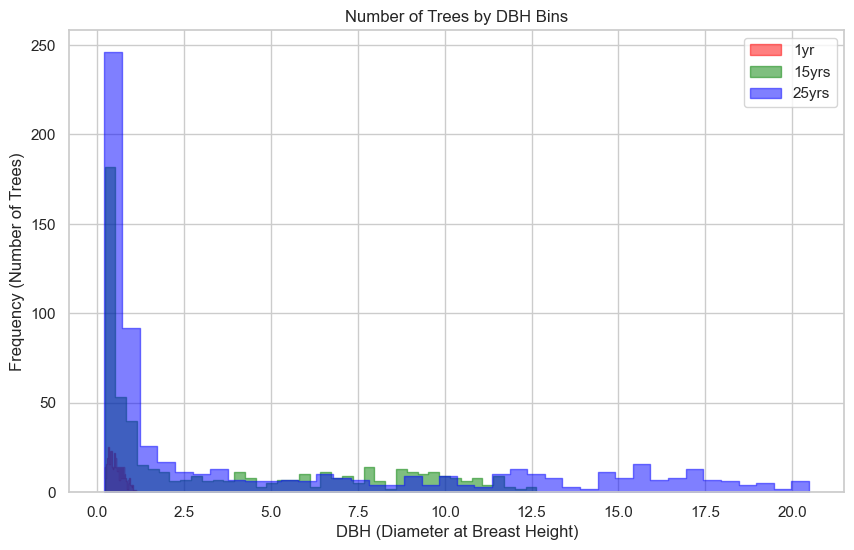

In [14]:
year_1_agents = agents.loc[agents['Step'] == 1]
year_15_agents = agents.loc[agents['Step'] == 15]
year_25_agents = agents.loc[agents['Step'] == 25]
print(year_1_agents.head())
print(type(year_1_agents))

avg_dbh_year_1 = year_1_agents['dbh'].mean()
avg_dbh_year_15 = year_15_agents['dbh'].mean()

# scatter plot all DBH year 1 and 15
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of the seaborn plot
sns.set(style="whitegrid")

# Define the number of bins you'd like, or let pandas choose automatically
num_bins = 40  # for example

# Define bin edges or let pandas calculate them
# For instance, bin edges that span from the min to max DBH, divided into intervals of 0.5
bin_edges = pd.interval_range(start=min(year_1_agents["dbh"].min(), year_15_agents["dbh"].min(), year_25_agents["dbh"].min()),
                              end=max(year_1_agents["dbh"].max(), year_15_agents["dbh"].max(), year_25_agents["dbh"].max()),
                              freq=0.5, closed='right')

# Bin the data
year_1_agents['binned'] = pd.cut(year_1_agents["dbh"], bins=bin_edges)
year_15_agents['binned'] = pd.cut(year_15_agents["dbh"], bins=bin_edges)
year_25_agents['binned'] = pd.cut(year_25_agents["dbh"], bins=bin_edges)

# Now calculate the counts for each bin
freq_1 = year_1_agents['binned'].value_counts().reset_index().rename(columns={'index': 'dbh', 'binned': 'frequency'})
freq_15 = year_15_agents['binned'].value_counts().reset_index().rename(columns={'index': 'dbh', 'binned': 'frequency'})
freq_25 = year_25_agents['binned'].value_counts().reset_index().rename(columns={'index': 'dbh', 'binned': 'frequency'})

# Sort by the bin
freq_1 = freq_1.sort_values('dbh')
freq_15 = freq_15.sort_values('dbh')
freq_25 = freq_25.sort_values('dbh')

# Since we're using interval data now, we should take the middle point of the intervals for plotting
freq_1['dbh_mid'] = freq_1['dbh'].apply(lambda x: x.mid)
freq_15['dbh_mid'] = freq_15['dbh'].apply(lambda x: x.mid)
freq_25['dbh_mid'] = freq_25['dbh'].apply(lambda x: x.mid)

# Create scatter plot
plt.figure(figsize=(10, 6))

# Since Seaborn's histplot automatically calculates bins, we can input the data directly
sns.histplot(year_1_agents["dbh"], bins=num_bins, color="red", label='1yr', kde=False, element="step", stat="count")
sns.histplot(year_15_agents["dbh"], bins=num_bins, color="green", label='15yrs', kde=False, element="step", stat="count")
sns.histplot(year_25_agents["dbh"], bins=num_bins, color="blue", label='25yrs', kde=False, element="step", stat="count")

# Add some transparency to the histograms
plt.gca().get_children()[0].set_alpha(0.5)
plt.gca().get_children()[1].set_alpha(0.5)
plt.gca().get_children()[2].set_alpha(0.5)

plt.title('Number of Trees by DBH Bins')
plt.xlabel('DBH (Diameter at Breast Height)')
plt.ylabel('Frequency (Number of Trees)')
plt.legend()
plt.show()
